In [1]:
import json
import codecs
import os
import pandas as pd

<h2>0. Gathering the Data</h2>
<p>In this preliminary section, we will gather all of the cuneiform sign transliterations from the JSON files in our dataset. Then we will consolidate them into a data frame and match each sign value with its sign name</p>

(Do we need to discuss the basics of cuneiform transliteration or is it assumed that our audience is familiar with it?)

<h3>0.1: OGSL</h3>
<p>Now, we will load a map from sign value to sign name to use on the signs in our texts. The OGSL is... (website...)</p>

In [2]:
file_ogsl = codecs.open('ogsl-sl.json','r','utf-8')
ogsl = json.load(file_ogsl)
sign_index = ogsl['index']
sign_index

{'ʾu₄': 'A',
 'a': 'A',
 'aia₂': 'A',
 'aya₂': 'A',
 'barₓ': 'U',
 'buniŋₓ': 'A',
 'burₓ': '|4×TAB|',
 'dur₅': 'A',
 'duru₅': 'A',
 'e₄': 'A',
 'ea': 'A',
 'ebir₃': 'A',
 'emₓ': 'A',
 'epir₃': 'A',
 'eš₁₀': 'A',
 'ŋa₁₀': 'A',
 'ia₁₀': 'A',
 'id₅': 'A',
 'me₅': 'A',
 'mu₁₄': 'A',
 'sedₓ': '|MUŠ₃×DI|',
 'šegₓ': '|URU×ŠE|',
 'ṭur₅': 'A',
 'ya₁₀': 'A',
 'ai': '|A.A|',
 'aia': '|A.A|',
 'aya': '|A.A|',
 'aye': '|A.A|',
 'ayi': '|A.A|',
 'ayu': '|A.A|',
 'ayya': '|A.A|',
 'ayye': '|A.A|',
 'ayyi': '|A.A|',
 'ayyu': '|A.A|',
 'iya': '|A.A|',
 'iyi': '|A.A|',
 'iyu': '|A.A|',
 'iyya': '|A.A|',
 'iyyi': '|A.A|',
 'iyyu': '|A.A|',
 'yaₓ': '|UD.NI|',
 'ayayaₓ': '|A.A.A|',
 'a₄': '|A.AN|',
 'am₃': '|A.AN|',
 'še₇': '|A.AN|',
 'šeg₃': '|A.AN|',
 'šeŋ₃': '|A.AN|',
 'šemₓ': 'NE',
 'maštabaₓ': '|A.BI|',
 'a-ra₂': '|A.DU|',
 'tuše': '|A.DU|',
 'tuššuru': '|A.DU|',
 'eribₓ': '|SAL.UD|',
 'eru₄': '|A.EDIN|',
 'erua': '|A.EDIN|',
 'erum₄': '|A.EDIN|',
 'ummuₓ': '|EDIN.LAL.A|',
 'ummudₓ': '|A.U.EDIN.LAL|',

<h3>0.2: Collect the Text Signs</h3>
<p>The following code parses the JSON files of the ORACC texts and collects each sign transliteration. Since different signs have different types of reading, they are rendered differently in the JSON file and we must take care to recognize each sign reading type in the JSON file</p>
The types of signs and their representation in the JSON Files:
<ol>
    <li>Syllable - The reading of a sign as a syllable is rendered with a 'v' key</li>
    <li>Logogram - The reading of a sign as a logogram, i.e. one represents a word in itself or as part of a complex of signs that represents a single word is written in capital letters and with a 's' key</li>
    <li>Numerical - A sign representing a number (or personal name determinative) has an extra key called 'sexified'. This gives information on the number sign's wedge structure.</li>
</ol>

In addition, a modified sign can be any of the three types above, but written with a nonstandard paleography (e.g. a diagonal wedge is incised in the clay instead of a horizontal). These are the signs we want to examine. They have extra data given under the 'mods' key.

In [3]:
def process_signs(sign_data):
    sign_info = {}
    if 'v' in sign_data:
        sign_info['b'] = sign_data['v']
    if 's' in sign_data:
        sign_info['b'] = sign_data['s']
    if 'n' in sign_data:
        sign_info['b'] = sign_data.get('sexified',sign_data.get('form','noform?'))
    if 'mods' in sign_data:
        for m in sign_data['mods']:
            for d in m:
                sign_info[d] = m[d]
    if 'break' in sign_data:
        sign_info['break'] = sign_data['break']
    sign_info['sign_loc_id'] = sign_data.get('id','no-id')
    return sign_info    

In [4]:
types = set()
all_signs = []
for fname in os.listdir('corpusjson'):
    #if not fname == 'P224485.json':
    #    continue
    f = codecs.open('corpusjson/'+fname,'r','utf-8')
    j = json.load(f)
    #print(str(len(j['cdl'][0]['cdl'])))
    #print(fname)
    for a in j['cdl'][0]['cdl']:
        if a.get('type','') == 'discourse':
            for b in a['cdl']:
                if b.get('type','') == 'sentence':
                    line_label = ''                    
                    for c in b['cdl']:
                        if c.get('node','') == 'd': #This is the label for the line e.g. "o ii 3"
                            line_label = c.get('label','nolabel')
                        if c.get('node','') == 'l':
                            form = c['f']['form']
                            for sign_data in c['f']['gdl']:
                                if sign_data.get('det','') == 'semantic':
                                    for sd in sign_data['seq']:
                                        sign_info = process_signs(sd)
                                        sign_info.update({'file':fname,'line_label':line_label,'form': form})
                                        all_signs.append(sign_info)
                                else:
                                    sign_info = process_signs(sign_data)
                                    sign_info.update({'file':fname,'line_label':line_label,'form': form})
                                    all_signs.append(sign_info)
                        if c.get('node','') == 'c':
                            for d in c['cdl']:
                                if d.get('node','') == 'l':
                                    form = d['f']['form']
                                    for sign_data in d['f']['gdl']:
                                        if sign_data.get('det','') == 'semantic':
                                            for sd in sign_data['seq']:
                                                sign_info = process_signs(sd)
                                                sign_info.update({'file':fname,'line_label':line_label,'form': form})
                                                all_signs.append(sign_info)
                                        else:
                                            sign_info = process_signs(sign_data)
                                            sign_info.update({'file':fname,'line_label':line_label,'form': form})
                                            all_signs.append(sign_info)
                        #types.add(c.get('type','no type'))
                        
all_signs

[{'b': 'a',
  'break': 'damaged',
  'file': 'P224485.json',
  'form': 'a-bat',
  'line_label': 'o 1',
  'sign_loc_id': 'P224485.2.1.0'},
 {'b': 'bat',
  'file': 'P224485.json',
  'form': 'a-bat',
  'line_label': 'o 1',
  'sign_loc_id': 'P224485.2.1.1'},
 {'b': 'LUGAL',
  'file': 'P224485.json',
  'form': 'LUGAL',
  'line_label': 'o 1',
  'sign_loc_id': 'P224485.2.2.0'},
 {'b': 'a',
  'file': 'P224485.json',
  'form': 'a-na',
  'line_label': 'o 1',
  'sign_loc_id': 'P224485.2.3.0'},
 {'b': 'na',
  'f': 't',
  'file': 'P224485.json',
  'form': 'a-na',
  'line_label': 'o 1',
  'sign_loc_id': 'P224485.2.3.1'},
 {'b': '1(diš)',
  'file': 'P224485.json',
  'form': '{1}aš-šur-MAN-PAB',
  'line_label': 'o 1',
  'sign_loc_id': 'P224485.2.4.0'},
 {'b': 'aš',
  'file': 'P224485.json',
  'form': '{1}aš-šur-MAN-PAB',
  'line_label': 'o 1',
  'sign_loc_id': 'P224485.2.4.1'},
 {'b': 'šur',
  'file': 'P224485.json',
  'form': '{1}aš-šur-MAN-PAB',
  'line_label': 'o 1',
  'sign_loc_id': 'P224485.2.4.2'

Now, we form our Data Frame where each row contains information on every sign in the corpus. Further limitations on which signs are significant to our purposes will be made later, but for now we will eliminate all of the signs which are labelled as "missing," (i.e. reconstructed) because any information based on their paleography or orthography cannot be ascertained.

In [5]:
df = pd.DataFrame(all_signs)
df = df.fillna('')
df = df[(df['break'] != 'missing')]
df

,a,b,break,f,file,form,line_label,m,sign_loc_id
0,,a,damaged,,P224485.json,a-bat,o 1,,P224485.2.1.0
1,,bat,,,P224485.json,a-bat,o 1,,P224485.2.1.1
2,,LUGAL,,,P224485.json,LUGAL,o 1,,P224485.2.2.0
3,,a,,,P224485.json,a-na,o 1,,P224485.2.3.0
4,,na,,t,P224485.json,a-na,o 1,,P224485.2.3.1
5,,1(diš),,,P224485.json,{1}aš-šur-MAN-PAB,o 1,,P224485.2.4.0
6,,aš,,,P224485.json,{1}aš-šur-MAN-PAB,o 1,,P224485.2.4.1
7,,šur,,,P224485.json,{1}aš-šur-MAN-PAB,o 1,,P224485.2.4.2
8,,MAN,,,P224485.json,{1}aš-šur-MAN-PAB,o 1,,P224485.2.4.3
9,,PAB,damaged,,P224485.json,{1}aš-šur-MAN-PAB,o 1,,P224485.2.4.4


<h3>1. Setting Up the Data for Clustering</h3>
<p>The general goal is to assign a vector to each text that reflects the usage of variant orthography and paleography.</p>
<ol>
    <li>Paleography - Any one set of wedges that we classify as a sign can be impressed on the clay in different ways. For example, a wedge can be missing or one can be added. Also, the tilt of a wedge can variable. These are the features we want to examine in order to see if one text prefers one sign writing or another.</li>
    <li>Orthography - Due to the homophony of the cuneiform writing system, one syllable can be written with many signs. For example, 'li' can be written with the LI-sign but also with the NI-sign, in which case it would be transliterated as li<sub>2</sub></li>
</ol>
<p>Other variables can be applied to a text as attributes in its vector. (What are these? We talked about things like Provenence, city information, scribe information. Also, if we apply different types of variables how can we use a clustering algorithm to treat these vector components as a different entity?).</p>
<p>This section therefore contains two subsections. One groups the diagnostic signs with or without modifications per text to. The other discovers the homophonous signs used throughout the corpus and groups different usages per text</p>

First of all, let's create more columns in the data frame to aid us
<ol>
<li>mods_str - Since the data contains three columns currently with information on variable paleography, it would help us to consolidate them into one column</li>
<li>str_part and num_part - In order to determine which signs share a syllabic value, it will be useful to separate the transliterated readings into their string components and numerical components. Once we do this, we can group rows with the same str_part and count up the different usages of homophonous signs</li>

In [6]:
df['sign_form'] = df['b'].apply(lambda x: sign_index.get(x.lower(),'?'))
df['mods_str'] = df['a'] + '.' + df['f'] + '.' + df['m']

import re
def get_num_part(s):
    try:
        n = re.findall(r'[₀₁₂₃₄₅₆₇₈₉]+',s)[0]
        n = n.replace('₀','0').replace('₁','1').replace('₂','2').replace('₃','3').replace('₄','4')
        n = n.replace('₅','5').replace('₆','6').replace('₇','7').replace('₈','8').replace('₉','9')
    except:
        n = 1
    return n
def get_str_part(s):
    try:
        n = re.findall(r'[a-zA-ZšŠṣṢṭṬʾ \(\)0-9]+',s)[0]
    except:
        n = s
    return n
        
df['str_part'] = df['b'].apply(lambda x: get_str_part(x))
df['num_part'] = df['b'].apply(lambda x: get_num_part(x))
df

,a,b,break,f,file,form,line_label,m,sign_loc_id,sign_form,mods_str,str_part,num_part
0,,a,damaged,,P224485.json,a-bat,o 1,,P224485.2.1.0,A,..,a,1
1,,bat,,,P224485.json,a-bat,o 1,,P224485.2.1.1,BAD,..,bat,1
2,,LUGAL,,,P224485.json,LUGAL,o 1,,P224485.2.2.0,LUGAL,..,LUGAL,1
3,,a,,,P224485.json,a-na,o 1,,P224485.2.3.0,A,..,a,1
4,,na,,t,P224485.json,a-na,o 1,,P224485.2.3.1,NA,.t.,na,1
5,,1(diš),,,P224485.json,{1}aš-šur-MAN-PAB,o 1,,P224485.2.4.0,DIŠ,..,1(diš),1
6,,aš,,,P224485.json,{1}aš-šur-MAN-PAB,o 1,,P224485.2.4.1,AŠ,..,aš,1
7,,šur,,,P224485.json,{1}aš-šur-MAN-PAB,o 1,,P224485.2.4.2,SUR,..,šur,1
8,,MAN,,,P224485.json,{1}aš-šur-MAN-PAB,o 1,,P224485.2.4.3,|U.U|,..,MAN,1
9,,PAB,damaged,,P224485.json,{1}aš-šur-MAN-PAB,o 1,,P224485.2.4.4,PAP,..,PAB,1


<h3>1.1: Collection of Modified Signs</h3>
<p>The Data Frame we have contains the entire collection of signs in the corpus. However, not every sign has variants in paleography (at least according to Parpola's data input). We only want to look at the signs which have these variants, which we will term diagnostic. In the data, they are the signs that include any type of modification</p>

In [7]:
df2 = df[~(df['f'] == '') | ~(df['a'] == '') | ~(df['m'] == '')]
mod_signs = sorted(list(df2['sign_form'].unique()))
mod_signs

['A',
 'AK',
 'AL',
 'ALEPH',
 'ANŠE',
 'APIN',
 'ARAD',
 'A₂',
 'BA',
 'BAD',
 'BAL',
 'BARA₂',
 'BI',
 'BU',
 'BUR',
 'DA',
 'DI',
 'DIB',
 'DIM',
 'DIN',
 'DU',
 'DUB',
 'DUN',
 'E',
 'E₂',
 'GABA',
 'GAD',
 'GAL',
 'GAR',
 'GI',
 'GIŠ',
 'HA@g',
 'HI',
 'HU',
 'IG',
 'IGI',
 'IL',
 'IN',
 'IR',
 'IŠ',
 'KA',
 'KAK',
 'KAL',
 'KAM₂',
 'KA₂',
 'KI',
 'KIN',
 'KU',
 'KUL',
 'KUN',
 'KUR',
 'LA',
 'LAGAB',
 'LI',
 'LIL',
 'LIŠ',
 'LU',
 'LUGAL',
 'LUH',
 'LU₂',
 'MA',
 'MA@g',
 'MAR',
 'MU',
 'MURUB₄',
 'MUŠ',
 'NA',
 'NAGAR',
 'NAM',
 'NA₂',
 'NE@s',
 'NI',
 'NU',
 'NUN',
 'PAP',
 'RA',
 'RI',
 'RU',
 'SA',
 'SAG',
 'SAR',
 'SIG',
 'SIG₄',
 'SILA₃',
 'SU',
 'SUM',
 'TA',
 'TAG',
 'TAR',
 'TE',
 'TI',
 'TU',
 'TUG₂',
 'TUK',
 'UB',
 'UM',
 'UR',
 'URI',
 'URU',
 'URUDA',
 'U₂',
 'ZAG',
 'ZI',
 'ZIG',
 'ZU',
 '|A.LAGAB×HAL|',
 '|AB×HA|',
 '|AŠ@z&AŠ@z&AŠ@z&AŠ@z|',
 '|EZEN×BAD|',
 '|GA₂×NUN&NUN|',
 '|GI%GI|',
 '|GUD×KUR|',
 '|HI×AŠ₂|',
 '|IGI.DIB|',
 '|KA×A|',
 '|LAGAB×SUM|',
 '|ME.U.U.U|

We now limit our Data Frame to include ONLY these diagnostic signs.

In [8]:
df_modsigns = df[df['sign_form'].isin(mod_signs)]
#remove damaged signs too
df_modsigns = df_modsigns[df_modsigns['break'] != 'damaged']
df_modsigns

,a,b,break,f,file,form,line_label,m,sign_loc_id,sign_form,mods_str,str_part,num_part
1,,bat,,,P224485.json,a-bat,o 1,,P224485.2.1.1,BAD,..,bat,1
2,,LUGAL,,,P224485.json,LUGAL,o 1,,P224485.2.2.0,LUGAL,..,LUGAL,1
3,,a,,,P224485.json,a-na,o 1,,P224485.2.3.0,A,..,a,1
4,,na,,t,P224485.json,a-na,o 1,,P224485.2.3.1,NA,.t.,na,1
11,,mu,,,P224485.json,šul-mu,o 1,,P224485.2.5.1,MU,..,mu,1
14,,ši,,,P224485.json,ia-a-ši,o 1,,P224485.2.6.2,IGI,..,ši,1
16,,mu,,,P224485.json,šul-mu,o 2,,P224485.3.1.1,MU,..,mu,1
17,,a,,,P224485.json,a-na,o 2,,P224485.3.2.0,A,..,a,1
18,,na,,t,P224485.json,a-na,o 2,,P224485.3.2.1,NA,.t.,na,1
19,,KUR,,,P224485.json,KUR-aš-šur{KI},o 2,,P224485.3.3.0,KUR,..,KUR,1


<h3>1.2: Collection of Homophonous Signs</h3>
<p>We now limit the original data frame in different way based on orthography. First we need to figure out which syllabic readings have multiple signs that can render them.</p>

In [9]:
df2 = pd.DataFrame(df.groupby(['str_part'])['num_part'].agg('nunique'))
ortho_list = list(df2[df2[('num_part')] > 1].index)
ortho_list

['A',
 'BAD',
 'DU',
 'DUG',
 'GIN',
 'I',
 'KA',
 'KAM',
 'KU',
 'KUR',
 'KUŠ',
 'LU',
 'MA',
 'NA',
 'NIGIR',
 'SIG',
 'TUR',
 'U',
 'UŠ',
 'ZU',
 'a',
 'ar',
 'aš',
 'be',
 'bil',
 'da',
 'daq',
 'du',
 'gir',
 'gur',
 'i',
 'ia',
 'il',
 'in',
 'kal',
 'lah',
 'li',
 'me',
 'mi',
 'pil',
 'qi',
 'rig',
 'tu',
 'u',
 'ur',
 'ša',
 'šu',
 'šum',
 'ṭe',
 'ṭi']

We need to eliminate capital letter entries because indices on logograms indicate different words and are not relevant here.

In [11]:
ortho_list = [h for h in ortho_list if len(re.findall(r'[A-Z]',h)) == 0]
ortho_list

['a',
 'ar',
 'aš',
 'be',
 'bil',
 'da',
 'daq',
 'du',
 'gir',
 'gur',
 'i',
 'ia',
 'il',
 'in',
 'kal',
 'lah',
 'li',
 'me',
 'mi',
 'pil',
 'qi',
 'rig',
 'tu',
 'u',
 'ur',
 'ša',
 'šu',
 'šum',
 'ṭe',
 'ṭi']

Limit the dataframe to only these signs

In [12]:
df_ortho_signs = df[df['str_part'].isin(ortho_list)]
df_ortho_signs

,a,b,break,f,file,form,line_label,m,sign_loc_id,sign_form,mods_str,str_part,num_part
0,,a,damaged,,P224485.json,a-bat,o 1,,P224485.2.1.0,A,..,a,1
3,,a,,,P224485.json,a-na,o 1,,P224485.2.3.0,A,..,a,1
6,,aš,,,P224485.json,{1}aš-šur-MAN-PAB,o 1,,P224485.2.4.1,AŠ,..,aš,1
12,,ia,,,P224485.json,ia-a-ši,o 1,,P224485.2.6.0,|I.A|,..,ia,1
13,,a,damaged,,P224485.json,ia-a-ši,o 1,,P224485.2.6.1,A,..,a,1
17,,a,,,P224485.json,a-na,o 2,,P224485.3.2.0,A,..,a,1
20,,aš,,,P224485.json,KUR-aš-šur{KI},o 2,,P224485.3.3.1,AŠ,..,aš,1
28,,ša,damaged,,P224485.json,ša,o 3,,P224485.4.1.0,ŠA,..,ša,1
34,,a,,,P224485.json,ma-a,o 3,,P224485.4.3.1,A,..,a,1
45,,me,,,P224485.json,{1}me-ta-a,o 3,,P224485.4.6.1,ME,..,me,1


<h3>Mixed vs. Complementary Distribution</h3>
<p>One of the goals of this project is to determine a preference for sign usage in one subgroup of the corpus versus another. To that end there is one more factor that needs to be discussed, namely the usage of these paleographic or orthographic variants within context. If the usage of these variants are context-dependent, meaning that one form or syllable is used in one context and another form or syllable in another context, it does not tell us much about the preferential usage of the signs. This is known as a complementary distribution. For example, if a scribe uses <i>li<sub>2</sub></i> only in the form of the word be-li<sub>2</sub> and the <i>li</i> sign in all other contexts, the choice of sign usage is not determined by the scribe's preference rather on scribal convention. This convention would thus be utilized by every scribe of this corpus and not help us to detect subgroups among these texts where scribes differ.</p>
<p>On the other hand, if sign form or syllable variants appear within the same contexts, it gives us the information we want on scribal writing preference or tendencies. For example, <i>ia</i> and <i>ia<sub>2</sub></i> both appear in forms of the word bēliya, meaning that a scribe had an option of orthography and incised one or the other. (NTS: I'm avoiding the term "choose" here because it is a very loaded term with implications that may be misleading here). The question then becomes whether certain texts group together based on their tendencies to use one variant within a mixed distribution versus another variant.</p>
<p>(paragraph about this dichotomy on the paleographic side of things. Mention TA vs. TA@v)</p>
<p>(closing paragraph summarizing the issue)</p>

Now let's try to apply a quantitative method to figure out the level of mixed distribution which orthographic variants bear within word forms. The steps here are:
<ol>
<li>Create a dictionary that hashes each syllable to a list of its orthographic variants</li>
<li>Count up the number of instances of one orthographic variant being used in each word form</li>
<li>Match up the word forms with either variant and see the total numbers of that one word form with both variants together</li>
</ol>


In [13]:
df_agg = pd.DataFrame(df_ortho_signs.groupby(['str_part','b'])['a'].agg('count')).reset_index()
df_agg.columns = ['str_part','b','count']
ortho_list_tuples = {}
for i, row in df_agg.iterrows():
    if row['str_part'] in ortho_list_tuples:
        ortho_list_tuples[row['str_part']].append(row['b'])
    else:
        ortho_list_tuples[row['str_part']] = [row['b']]

#clean up the u and ṭe directly. It is easier
ortho_list_tuples['u1'] = ['u','u₂']
ortho_list_tuples['u2'] = ['u','u₃']
ortho_list_tuples['u3'] = ['u₂','u₃']
ortho_list_tuples['ṭe1'] = ['ṭe','ṭe₂']
ortho_list_tuples['ṭe2'] = ['ṭe','ṭe₃']
ortho_list_tuples['ṭe3'] = ['ṭe₂','ṭe₃']
ortho_list_tuples

{'a': ['a', 'a₂'],
 'ar': ['ar', 'ar₂'],
 'aš': ['aš', 'aš₂'],
 'be': ['be', 'be₂'],
 'bil': ['bil', 'bil₂'],
 'da': ['da', 'da₃'],
 'daq': ['daq', 'daq₃'],
 'du': ['du', 'du₆'],
 'gir': ['gir', 'gir₂'],
 'gur': ['gur', 'gur₂'],
 'i': ['i', 'i₃'],
 'ia': ['ia', 'ia₂'],
 'il': ['il', 'il₃'],
 'in': ['in', 'in₆'],
 'kal': ['kal', 'kal₃'],
 'lah': ['lah₂', 'lah₃'],
 'li': ['li', 'li₂'],
 'me': ['me', 'me₂'],
 'mi': ['mi', 'mi₃'],
 'pil': ['pil', 'pil₂'],
 'qi': ['qi', 'qi₂'],
 'rig': ['rig', 'rig₂'],
 'tu': ['tu', 'tu₂'],
 'u': ['u', 'u₂', 'u₃'],
 'u1': ['u', 'u₂'],
 'u2': ['u', 'u₃'],
 'u3': ['u₂', 'u₃'],
 'ur': ['ur', 'ur₂'],
 'ša': ['ša', 'ša₂'],
 'šu': ['šu', 'šu₂'],
 'šum': ['šum', 'šum₂'],
 'ṭe': ['ṭe', 'ṭe₂', 'ṭe₃'],
 'ṭe1': ['ṭe', 'ṭe₂'],
 'ṭe2': ['ṭe', 'ṭe₃'],
 'ṭe3': ['ṭe₂', 'ṭe₃'],
 'ṭi': ['ṭi', 'ṭi₂']}

In [14]:
df_form_counts = pd.DataFrame(df_ortho_signs.groupby(['str_part','b','form'])['a'].agg('count'))
df_form_counts = df_form_counts.reset_index()
df_form_counts = df_form_counts.sort_values(by=['b','a'],ascending=[True,False])
df_form_counts

,str_part,b,form,a
77,a,a,a-na,580
229,a,a,ma-a,370
277,a,a,u₂-ma-a,63
129,a,a,a-ta-a,59
219,a,a,la-a,51
82,a,a,a-na-ku,35
3,a,a,EN-a,32
30,a,a,a-dan-niš,28
32,a,a,a-di,28
34,a,a,a-du,24


In [15]:
df_form_counts.to_csv('output/form_counts.csv',encoding='utf-8',index=False)

In [17]:
l_mixed = []
for k in ortho_list_tuples:
    if(len(ortho_list_tuples[k]) == 2):
        df_ortho1 = df_form_counts[df_form_counts['b'] == ortho_list_tuples[k][0]]
        df_ortho2 = df_form_counts[df_form_counts['b'] == ortho_list_tuples[k][1]]
        total_count = 0
        mixed_count = 0
        for i, row1 in df_ortho1.iterrows():
            form1 = re.sub(r'' + k + '[₁₂₃₄₅₆₇₈₉₀]+',k,row1['form'])
            for j, row2 in df_ortho2.iterrows():
                total_count += 1
                form2 = re.sub(r'' + k + '[₁₂₃₄₅₆₇₈₉₀]+',k,row2['form'])
                if form1 == form2:
                    data = {
                        'str_part': k,
                        'form1': row1['form'],
                        'form1_c': row1['a'],
                        'form2': row2['form'],
                        'form2_c': row2['a'],
                        'form_base': form1,
                    }
                    l_mixed.append(data)

df_mixed = pd.DataFrame(l_mixed)
df_mixed['total_mixed'] = df_mixed['form1_c'] * df_mixed['form2_c']
df_mixed

,form1,form1_c,form2,form2_c,form_base,str_part,total_mixed
0,{KUR}ar-pa-a.a,2,{KUR}ar₂-pa-a.a,1,{KUR}ar-pa-a.a,ar,2
1,ar-hiš,1,ar₂-hiš,9,ar-hiš,ar,9
2,{URU}ar-pad-da,1,{URU}ar₂-pad-da,2,{URU}ar-pad-da,ar,2
3,šad-daq-diš,1,šad-daq₃-diš,1,šad-daq-diš,daq,1
4,e-gir-te,2,e-gir₂-te,2,e-gir-te,gir,4
5,e-gir-tu₂,2,e-gir₂-tu₂,13,e-gir-tu₂,gir,26
6,EN-ia,218,EN-ia₂,52,EN-ia,ia,11336
7,be-li₂-ia,43,be-li₂-ia₂,33,be-li₂-ia,ia,1419
8,{LU₂}A-šip-ri-ia,4,{LU₂}A-šip-ri-ia₂,2,{LU₂}A-šip-ri-ia,ia,8
9,{URU}kal-ha,18,{URU}kal₃-ha,1,{URU}kal-ha,kal,18


In [18]:
df_mixed.to_csv('output/mixed_counts.csv',encoding='utf-8')

This is the chart to look at to see which orthographic variants are being employed in a meaningful mixed distribution.
<p>(A note here about perhaps having a cutoff point for total instances for one syllable)</p>
<p>(A note here about the important orthographic variation included in this chart and how to employ it in our text vector. Do we want to look at the variants only within the word forms with sufficient number of instances or across the whole text? I would say across the whole text. Do we want to restrict the dimensions of the text vectors to only orthographic variants that we select from the chart or employ a kind of weighting system which places more importance on the syllables that are important here? For now, I'm just going to limit it to particular syllables)</p>
<p>(ALSO, do we want to match up orthographic variants in the context of word forms OR in the context of 2-grams, per David's suggestion. I did entire word forms here, because I found the programming to be easier.)</p>

For now, let's just limit our text vectors to the distribution of 4 syllables: šu, ša, ia, li

In [45]:
df_4_syls = df_ortho_signs[df_ortho_signs['str_part'].isin(['šu','ša','ia','li'])]
df_4_syls = pd.DataFrame(df_4_syls.groupby(['file','str_part','b'])['a'].agg('count')).reset_index()
df_4_syls

,file,str_part,b,a
0,P224485.json,ia,ia,17
1,P224485.json,li,li,6
2,P224485.json,li,li₂,7
3,P224485.json,ša,ša,20
4,P224485.json,ša,ša₂,4
5,P224485.json,šu,šu,4
6,P224485.json,šu,šu₂,32
7,P313416.json,ia,ia,1
8,P313416.json,ia,ia₂,2
9,P313416.json,li,li₂,3


Let's form the text vectors

In [72]:
d_file_4_syls = {}
file_names = df_4_syls['file'].unique()
for f in file_names:
    d = {}
    for s in ['ia','ia₂','šu','šu₂','ša','ša₂','li','li₂']:
        try:
            n = int(df_4_syls[(df_4_syls['file'] == f) & (df_4_syls['b'] == s)]['a']) + 1
        except TypeError:
            n = 1
        d[s] = n
    
    ia_tot = d['ia'] + d['ia₂']
    su_tot = d['šu'] + d['šu₂']
    sa_tot = d['ša'] + d['ša₂']
    li_tot = d['li'] + d['li₂']
    
    d_file_4_syls[f] = [d['ia'] / ia_tot,d['ia₂'] / ia_tot,d['li'] / li_tot,d['li₂'] / li_tot,d['ša'] / sa_tot, d['ša₂'] / sa_tot,d['šu'] / su_tot,d['šu₂'] / su_tot]
df_file_4_syls = pd.DataFrame(d_file_4_syls).transpose()
df_file_4_syls.columns = ['ia','ia₂','li','li₂','ša','ša₂','šu','šu₂']
df_file_4_syls

,ia,ia₂,li,li₂,ša,ša₂,šu,šu₂
P224485.json,0.947368,0.052632,0.466667,0.533333,0.807692,0.192308,0.131579,0.868421
P313416.json,0.400000,0.600000,0.200000,0.800000,0.500000,0.500000,0.500000,0.500000
P313417.json,0.833333,0.166667,0.500000,0.500000,0.950000,0.050000,0.833333,0.166667
P313425.json,0.923077,0.076923,0.500000,0.500000,0.764706,0.235294,0.800000,0.200000
P313427.json,0.250000,0.750000,0.125000,0.875000,0.777778,0.222222,0.142857,0.857143
P313435.json,0.833333,0.166667,0.666667,0.333333,0.800000,0.200000,0.500000,0.500000
P313437.json,0.750000,0.250000,0.500000,0.500000,0.800000,0.200000,0.500000,0.500000
P313439.json,0.750000,0.250000,0.750000,0.250000,0.900000,0.100000,0.250000,0.750000
P313447.json,0.800000,0.200000,0.428571,0.571429,0.666667,0.333333,0.166667,0.833333
P313458.json,0.400000,0.600000,0.500000,0.500000,0.461538,0.538462,0.400000,0.600000


Cluster using K-Means

In [75]:
from sklearn.cluster import KMeans

km1 = KMeans(n_clusters=7, max_iter=1000).fit(df_file_4_syls)

labels_ortho = {}

km1.labels_

for i in range(len(km1.labels_)):
    if km1.labels_[i] in labels_ortho:
        labels_ortho[km1.labels_[i]].append(file_names[i])
    else:
        labels_ortho[km1.labels_[i]] = [file_names[i]]
labels_ortho


{0: ['P313435.json',
  'P313439.json',
  'P313491.json',
  'P313511.json',
  'P313543.json',
  'P313600.json',
  'P313614.json',
  'P313644.json',
  'P313660.json',
  'P313726.json',
  'P313755.json',
  'P313885.json',
  'P314022.json',
  'P314026.json',
  'P314048.json',
  'P314257.json',
  'P334037.json',
  'P334043.json',
  'P334044.json',
  'P334046.json',
  'P334079.json',
  'P334120.json',
  'P334124.json',
  'P334195.json',
  'P334284.json',
  'P334328.json',
  'P334359.json',
  'P334372.json',
  'P334496.json',
  'P334568.json',
  'P334689.json',
  'P334693.json',
  'P334699.json',
  'P334718.json',
  'P334721.json',
  'P334773.json',
  'P334774.json',
  'P334834.json',
  'P334864.json',
  'P334910.json',
  'P336167.json'],
 1: ['P313417.json',
  'P313425.json',
  'P313437.json',
  'P313487.json',
  'P313509.json',
  'P313629.json',
  'P313699.json',
  'P313722.json',
  'P313878.json',
  'P314223.json',
  'P314232.json',
  'P334054.json',
  'P334078.json',
  'P334083.json',
  '

Visualize with MDS

In [76]:
from sklearn.manifold import MDS

texts_2d_map = {}
texts = df_file_4_syls.index

mds1 = MDS(n_components = 2)
texts_2d = mds1.fit_transform(df_file_4_syls)

In [77]:
color_list = ['white','yellow','green','red','blue','brown','black']
colors_all = []
for i in range(len(km1.labels_)):
    colors_all.append(color_list[km1.labels_[i]])
colors_all

['red',
 'blue',
 'yellow',
 'yellow',
 'black',
 'white',
 'yellow',
 'white',
 'red',
 'brown',
 'yellow',
 'white',
 'blue',
 'black',
 'black',
 'yellow',
 'white',
 'black',
 'blue',
 'white',
 'brown',
 'red',
 'red',
 'brown',
 'white',
 'white',
 'green',
 'red',
 'brown',
 'yellow',
 'white',
 'red',
 'white',
 'green',
 'green',
 'yellow',
 'brown',
 'yellow',
 'white',
 'black',
 'black',
 'white',
 'red',
 'brown',
 'blue',
 'brown',
 'brown',
 'brown',
 'blue',
 'green',
 'yellow',
 'blue',
 'white',
 'blue',
 'green',
 'black',
 'green',
 'green',
 'blue',
 'green',
 'blue',
 'blue',
 'brown',
 'blue',
 'brown',
 'white',
 'white',
 'blue',
 'blue',
 'white',
 'red',
 'brown',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'yellow',
 'blue',
 'yellow',
 'blue',
 'black',
 'brown',
 'white',
 'blue',
 'green',
 'brown',
 'blue',
 'black',
 'red',
 'brown',
 'white',
 'blue',
 'brown',
 'black',
 'red',
 'brown',
 'white',
 'white',
 'green',
 'white',
 'red',
 'red',
 'red'

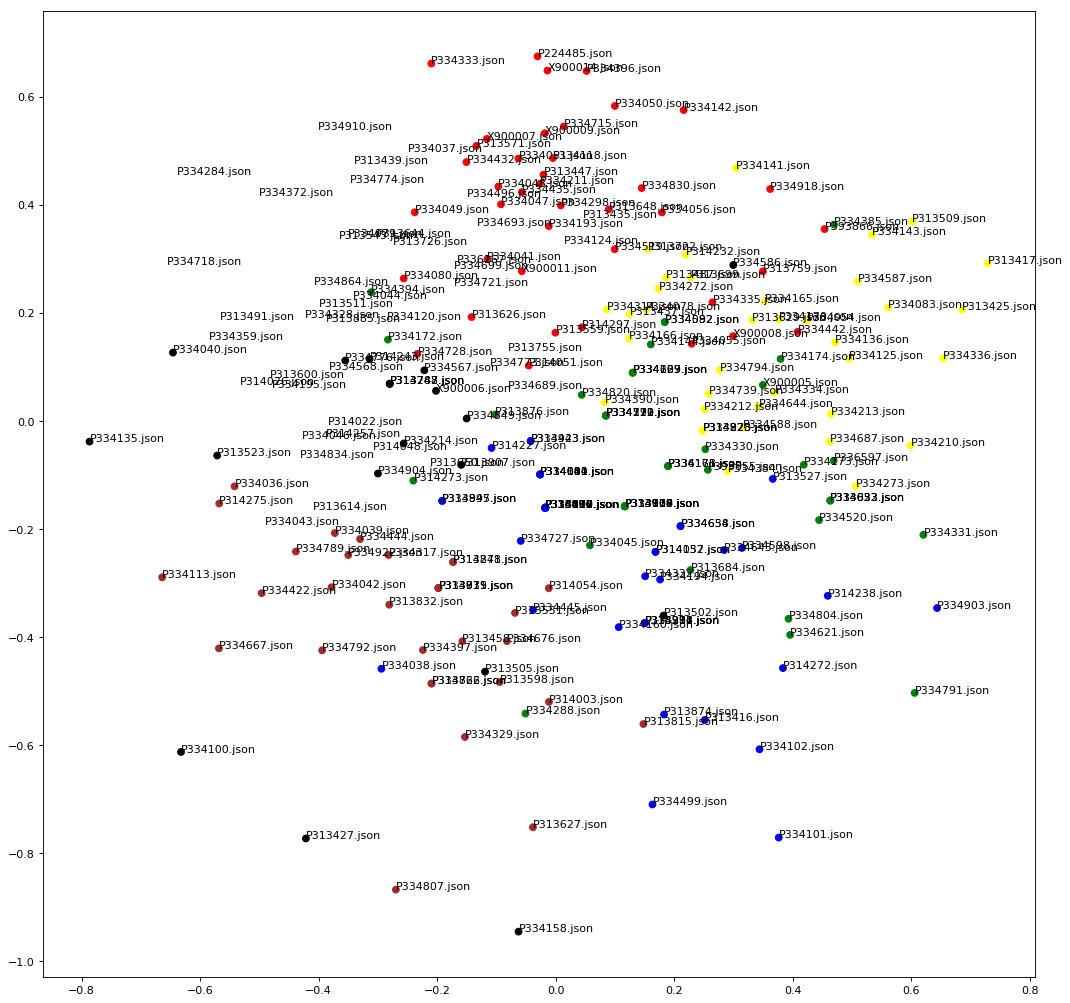

In [78]:
import matplotlib.pyplot as plt
plt.figure(num=None, figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')

x_values = [xy[0] for xy in texts_2d]
y_values = [xy[1] for xy in texts_2d]
plt.scatter(x_values,y_values,c=colors_all)
for i in range(len(texts_2d)):
    plt.annotate(texts[i],(x_values[i],y_values[i]))
plt.show()

THE FOLLOWING CONTAINS OLDER CODE from different attempts at forming text vectors. But I'm keeping it for now in case I need it.

<h2>2. Clustering</h2>

<h3>2.1 Tf-Idf</h3>
<p>We want to gather all of the signs with their variant orthographies into each text file and generate a vector which will contain a '1' if the text contains an orthography or sign value and a '0' if it does not.</p>
<p>(Here's where I am unsure of how to form the Tf-Idf matrix. The code currently counts ALL usages of the signs per file. But do we want to...</p>
<ol><li>Only give each sign usage a 1 or 0 value?</li><li>Keep the totals and normalize the vectors?</li></ol>
<p>Another thing to consider is if we want to combine Tf-Idf matrices, i.e. the sign orthography variants and the sign syllable variants. Would this be useful? Would we need to distinguish these qualities in the vectors somehow? The same issue occurs if we tack on other variables to the text)</p>

<b>2.1.1. Modified Signs Tf-Idf</b>

In [20]:
df_file_modsigns = pd.DataFrame(df_modsigns.groupby(['file']).apply(lambda x: ' '.join(x.sign_form+':'+x.mods_str))).reset_index()
df_file_modsigns.columns = ['file','mod_signs_all']
df_file_modsigns

,file,mod_signs_all
0,P224485.json,BAD:.. LUGAL:.. A:.. NA:.t. MU:.. IGI:.. MU:.....
1,P313416.json,NA:.. LUGAL:.. BAD:.. NI:.. ARAD:.. KA:.. LU:....
2,P313417.json,A:.. NA:.t. LUGAL:.p. ARAD:.. KA:.. NU:.. LU:....
3,P313425.json,NA:.. GI:.. ŠA:.d. BA:.. BAD:.. TI:.. |GUD×KUR...
4,P313427.json,BAD:.. NI:.. KUL:.d. DU:.. GIŠ:.. NA:.. LUGAL:...
5,P313435.json,A:.. NA:.. LUGAL:.. ARAD:.. KA:.. AK:.d. LU:.....
6,P313437.json,A:.. NA:.. LUGAL:.. ARAD:.. KA:.. HI:.. LU:.. ...
7,P313439.json,A:.. NA:.. ARAD:.. KA:.. LU:.. DI:.. MU:.. A:....
8,P313447.json,NA:.. LUGAL:.. KA:.. HI:.. DI:.d. MU:.. A:.. N...
9,P313458.json,ARAD:.. MU:.. A:.. NA:.. AK:.d. |ME.U.U.U|:.. ...


In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

trans = TfidfTransformer(smooth_idf=False)
vect = CountVectorizer(token_pattern='[^ ]+',lowercase=False)
vect_fit = vect.fit_transform(df_file_modsigns['mod_signs_all'])
tfidf_fit = trans.fit_transform(vect_fit)
tfidf1 = pd.DataFrame(tfidf_fit.toarray(),columns=vect.get_feature_names(),index=df_file_modsigns.file)
tfidf1

,A:..,A:.d.,AK:..,AK:.d.,AK:.t.,AK:.td.,AL:..,AL:.d.,AL:.t.,AL:.y.,...,ŠEŠ:..,ŠEŠ:.p.,ŠID:..,ŠID:.p.,ŠIM:..,ŠIM:.d.,ŠIM:.p.,ŠIM:.t.,ŠU₂:..,ŠU₂:.d.
file,,,,,,,,,,,,,,,,,,,,,
P224485.json,0.430222,0.000000,0.016592,0.000000,0.0,0.0,0.030584,0.000000,0.0,0.0,...,0.000000,0.0,0.033785,0.0,0.034097,0.0,0.0,0.051235,0.252499,0.000000
P313416.json,0.034988,0.000000,0.000000,0.142014,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
P313417.json,0.326584,0.000000,0.000000,0.000000,0.0,0.0,0.065006,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
P313425.json,0.330366,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
P313427.json,0.203607,0.000000,0.078526,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.354186,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.221292,0.000000
P313435.json,0.282771,0.000000,0.000000,0.191293,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.130730,0.0,0.0,0.000000,0.000000,0.000000
P313437.json,0.178683,0.000000,0.000000,0.000000,0.0,0.0,0.111146,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
P313439.json,0.343413,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.069672,0.000000
P313447.json,0.336523,0.000000,0.064894,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.066067,0.0,0.000000,0.0,0.0,0.000000,0.146301,0.000000


<b>2.1.2. TF-IDF for homophonous signs</b>

In [23]:
df_file_orthosigns = pd.DataFrame(df_ortho_signs.groupby(['file']).apply(lambda x: ' '.join(x.b))).reset_index()
df_file_orthosigns.columns = ['file','homo_signs_all']
df_file_orthosigns

,file,homo_signs_all
0,P224485.json,a a aš ia a a aš ša a me a ia a u ša u₂ a a u₂...
1,P313416.json,a be li₂ ia u a be li₂ ia₂ tu₂ u₂ me be li₂ ia₂
2,P313417.json,a a ša a u₂ u₂ a u₂ šu a a qi a il i i a du a ...
3,P313425.json,u ša mi i me u₂ u li a me ia tu₂ i ša ša u gir...
4,P313427.json,be li₂ ia₂ be li₂ ia₂ ia₂ a šu₂ i šu₂ ša be li...
5,P313435.json,a ia a ia u ia ša a me a aš ša me li a rig a t...
6,P313437.json,a ia aš a ia a u₃ aš du ša i u ša i il ša aš a
7,P313439.json,a aš u a ia aš a ia ša a a ša a ur da ša šu₂ š...
8,P313447.json,ia aš a ia ša be li₂ a tu₂ ša a i aš₂ i ša i š...
9,P313458.json,ia a ia₂ u ša ia₂ be li₂ li u aš u ša₂ a u₂ a ...


In [26]:
vect2 = CountVectorizer(token_pattern='[^ ]+',lowercase=False)
vect_fit2 = vect2.fit_transform(df_file_orthosigns['homo_signs_all'])
tfidf2 = pd.DataFrame(vect_fit2.toarray(),columns=vect2.get_feature_names(),index=df_file_orthosigns.file)
tfidf2

,a,ar,ar₂,aš,aš₂,a₂,be,be₂,bil,bil₂,...,ša₂,šu,šum,šum₂,šu₂,ṭe,ṭe₂,ṭe₃,ṭi,ṭi₂
file,,,,,,,,,,,,,,,,,,,,,
P224485.json,61,5,0,5,8,0,7,2,1,0,...,4,4,1,0,32,0,0,1,0,0
P313416.json,2,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P313417.json,27,0,0,0,1,0,0,0,0,0,...,0,4,0,0,0,1,0,1,0,0
P313425.json,32,4,0,0,1,0,4,0,0,0,...,3,3,1,1,0,0,0,0,0,0
P313427.json,8,0,0,0,0,0,5,0,0,0,...,1,0,0,2,5,0,0,0,0,0
P313435.json,7,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P313437.json,4,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P313439.json,13,0,1,2,1,0,0,0,0,0,...,0,0,1,0,2,0,0,0,0,0
P313447.json,14,0,0,1,2,0,3,0,0,0,...,2,0,0,0,4,0,0,0,0,2


<h3>2.2 K-Means Clustering</h3>
<p>Now we use K-means to cluster the texts. (K-means requires a determination of how many clusters to use. What is this number? How should we determine it?)</p>

<b>2.2.1. Clustering for Modified Signs</b>

In [27]:
from sklearn.cluster import KMeans

km1 = KMeans(n_clusters=7, max_iter=1000).fit(tfidf1)

labels_mods = {}

for i in range(len(km1.labels_)):
    if km1.labels_[i] in labels_mods:
        labels_mods[km1.labels_[i]].append(df_file_modsigns.file[i])
    else:
        labels_mods[km1.labels_[i]] = [df_file_modsigns.file[i]]
labels_mods

{0: ['P313417.json',
  'P313509.json',
  'P313684.json',
  'P313719.json',
  'P313904.json',
  'P313974.json',
  'P314051.json',
  'P334036.json',
  'P334040.json',
  'P334041.json',
  'P334042.json',
  'P334044.json',
  'P334045.json',
  'P334046.json',
  'P334047.json',
  'P334136.json',
  'P334166.json',
  'P334271.json',
  'P334272.json',
  'P334273.json',
  'P334329.json',
  'P334330.json',
  'P334332.json',
  'P334372.json',
  'P334512.json',
  'P334643.json',
  'P336167.json'],
 1: ['P313416.json',
  'P313491.json',
  'P313511.json',
  'P313543.json',
  'P313551.json',
  'P313571.json',
  'P313598.json',
  'P313600.json',
  'P313627.json',
  'P313699.json',
  'P313722.json',
  'P313726.json',
  'P313742.json',
  'P313748.json',
  'P313755.json',
  'P313762.json',
  'P313807.json',
  'P313864.json',
  'P313871.json',
  'P313874.json',
  'P313876.json',
  'P313879.json',
  'P313885.json',
  'P313897.json',
  'P313907.json',
  'P313919.json',
  'P313947.json',
  'P314001.json',
  '

Same for homophone signs

<b>2.2.2. Clustering for Homophonous Signs</b>

In [29]:
km2 = KMeans(n_clusters=7, max_iter=1000).fit(tfidf2)
labels_orthos = {}

for i in range(len(km2.labels_)):
    if km2.labels_[i] in labels_homos:
        labels_orthos[km2.labels_[i]].append(df_file_orthosigns.file[i])
    else:
        labels_orthos[km2.labels_[i]] = [df_file_orthosigns.file[i]]
labels_orthos

{0: ['X900005.json'],
 1: ['X900006.json'],
 2: ['P224485.json'],
 3: ['X900009.json'],
 4: ['P334143.json'],
 5: ['X900014.json'],
 6: ['P334830.json']}

<h3>2. Visualization</h3>

<b>2.1. Visualize from Modified Sign Clusters</b>

In [30]:
from sklearn.manifold import MDS

texts_2d_map = {}
texts = tfidf1.index

dim_num = len(vect.get_feature_names())
mds1 = MDS(n_components = 2)
texts_2d = mds1.fit_transform(tfidf1)

Set up colors for each cluster

In [31]:
color_list = ['white','yellow','green','red','blue','brown','black']
colors_all = []
for i in range(len(km1.labels_)):
    colors_all.append(color_list[km1.labels_[i]])
colors_all

['blue',
 'yellow',
 'white',
 'green',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'yellow',
 'blue',
 'blue',
 'black',
 'white',
 'yellow',
 'green',
 'brown',
 'yellow',
 'yellow',
 'blue',
 'yellow',
 'yellow',
 'yellow',
 'green',
 'black',
 'green',
 'yellow',
 'brown',
 'blue',
 'brown',
 'green',
 'black',
 'white',
 'yellow',
 'white',
 'yellow',
 'yellow',
 'yellow',
 'yellow',
 'yellow',
 'blue',
 'yellow',
 'yellow',
 'red',
 'red',
 'brown',
 'yellow',
 'yellow',
 'yellow',
 'yellow',
 'brown',
 'yellow',
 'yellow',
 'yellow',
 'white',
 'yellow',
 'brown',
 'yellow',
 'brown',
 'red',
 'yellow',
 'white',
 'black',
 'yellow',
 'red',
 'yellow',
 'yellow',
 'blue',
 'black',
 'yellow',
 'white',
 'blue',
 'yellow',
 'brown',
 'black',
 'yellow',
 'red',
 'yellow',
 'yellow',
 'blue',
 'green',
 'yellow',
 'blue',
 'brown',
 'red',
 'blue',
 'yellow',
 'red',
 'yellow',
 'yellow',
 'yellow',
 'green',
 'white',
 'blue',
 'brown',
 'brown',
 'white',
 'w

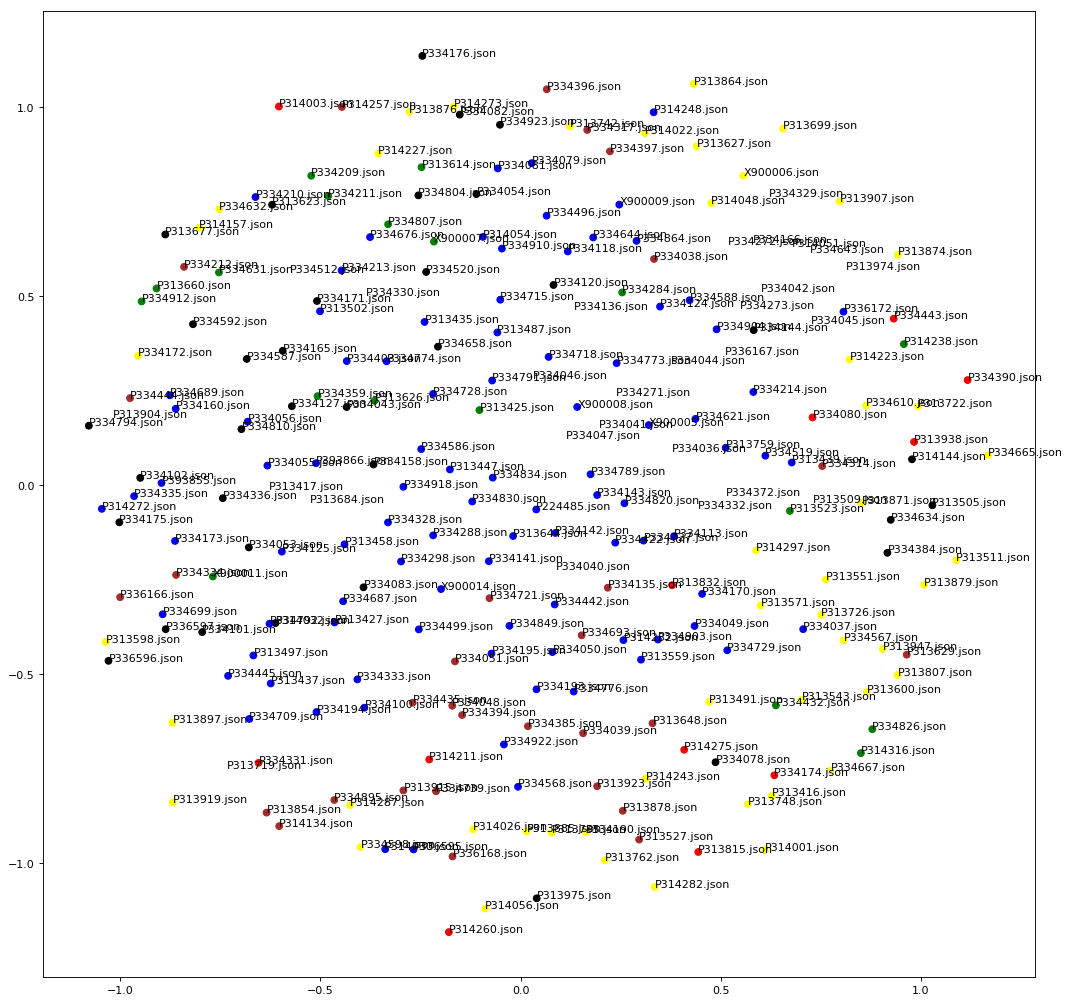

In [32]:
import matplotlib.pyplot as plt
plt.figure(num=None, figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')

x_values = [xy[0] for xy in texts_2d]
y_values = [xy[1] for xy in texts_2d]
plt.scatter(x_values,y_values,c=colors_all)
for i in range(len(texts_2d)):
    plt.annotate(texts[i],(x_values[i],y_values[i]))
plt.show()

<b>2.2 Same for homophone signs</b>

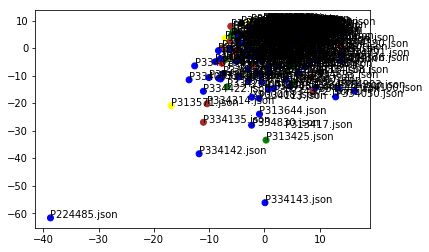

In [33]:
dim_num = len(vect2.get_feature_names())
mds2 = MDS(n_components = 2)
texts_2d = mds2.fit_transform(tfidf2)

x_values = [xy[0] for xy in texts_2d]
y_values = [xy[1] for xy in texts_2d]
plt.scatter(x_values,y_values,c=colors_all)
for i in range(len(texts_2d)):
    plt.annotate(texts[i],(x_values[i],y_values[i]))
plt.show()